## RFM Segmentation

#### What is RFM Segmentation?
RFM segmentation allows marketers to target specific clusters of customers with communications that are much more relevant for their particular behavior – and thus generate much higher rates of response, plus increased loyalty and customer lifetime value. Like other segmentation methods, RFM segmentation is a powerful way to identify groups of customers for special treatment. RFM stands for recency, frequency and monetary. [1]

#### What are Recency, Frequency and Monetary?
Recency (R): How much time has elapsed since a customer’s last activity or transaction with the brand? Activity is usually a purchase, although variations are sometimes used, e.g., the last visit to a website or use of a mobile app. In most cases, the more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to communications from the brand. [1]

Frequency (F): How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. And one-time-only customers are in a class of their own. [1]

Monetary (M): Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.

## 1. Importing Module

In [31]:
import numpy as np # Import NumPy for handling numerical operations
import pandas as pd # Import Pandas for data manipulation and analysis
pd.set_option('display.max_rows', 1000) # Set Pandas options to display a maximum of 1000 rows
from scipy.stats import norm 

# Import matplotlib, plotly and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import kaleido

# Set up matplotlib style
plt.style.available # Show list of available styles
plt.style.use('seaborn-v0_8-bright')

# Import warnings to ignore error
import warnings
warnings.filterwarnings("ignore")

# Import time and tqdm for measuring execution time
import time
import tqdm

# Import RareLabelEncoder from feature_engine.encoding for encoding categorical features
from feature_engine.encoding import RareLabelEncoder

# Import pycountry for converting country name to ISO 3166-1 alpha-3 name
import pycountry

## 2. Loading Data

In [32]:
#  Loading dataset
filepath = r"..\\RFM-Customers-Segmentation\data\Online_Retail.xlsx"
df = pd.read_excel(filepath, dtype={'CustomerID': str, 'StockCode': str, "InvoiceNo": str})

# Create a DataFrame contains data of cancelled invoices
canceled = df[df['InvoiceNo'].str.contains(pat=r'C|c', regex=True)]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

# Drop missing data in the dataset
print('Number of missing data in the dataset:')
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nDrop missing data:")
item0 = df.shape[0]
df = df.dropna(subset = ['CustomerID'])
item1 = df.shape[0]
print(f"- Total {item0-item1} rows dropped for missing values.")

# Drop duplicates
item0 = df.shape[0]
df = df.drop_duplicates()
item1 = df.shape[0]
print("\nDrop duplicates:")
print(f"- Total {item0-item1} row dropped for duplicates.")

# Drop incorrect values 
print('\nIncorrect values:')
for col in ["Quantity", "UnitPrice"]:  
    item0 = df.shape[0]
    # UnitPrice and Quantity must greater than zero to be acceptable
    df = df[df[col]>0]
    item1 = df.shape[0]
    print(f'- There are {item0-item1} incorrect data (which less than or equal to zero) in {col} column were dropped.')

# Add CountryCode column
def country_to_iso_alpha(country_name): # Defind a function to convert country name to country code
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_3
    except LookupError:
        return None
df['CountryCode'] = df['Country'].apply(country_to_iso_alpha)

# Print Final Result
print("\nOverview:")
print(df.info())
df.head(10)

## 3. Data Exploration

### Descriptive Statistic Analysis

In [ ]:
# Descriptive Analysis
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,392692.0,13.119702,1.0,2.0,6.0,12.0,80995.0,180.492832
InvoiceDate,392692,2011-07-10 19:13:07.771892480,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392692.0,3.125914,0.001,1.25,1.95,3.75,8142.75,22.241836
TotalPrice,392692.0,22.6315,0.001,4.95,12.45,19.8,168469.6,311.099224


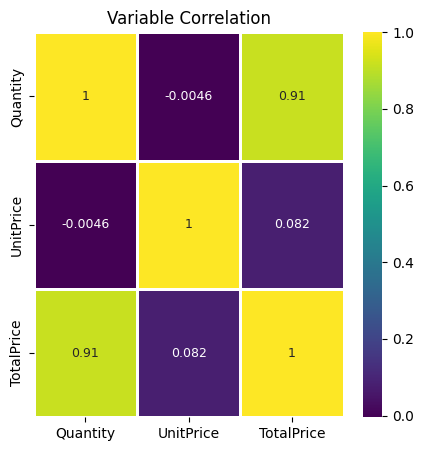

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, cmap = 'viridis',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation');

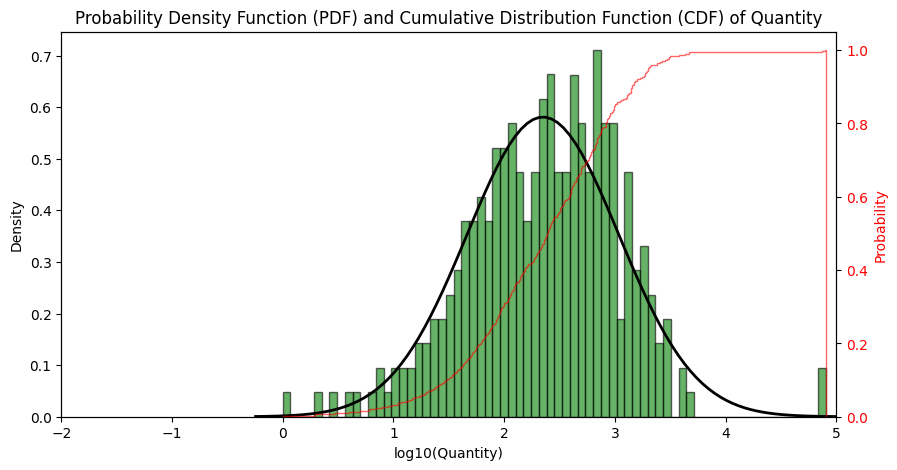

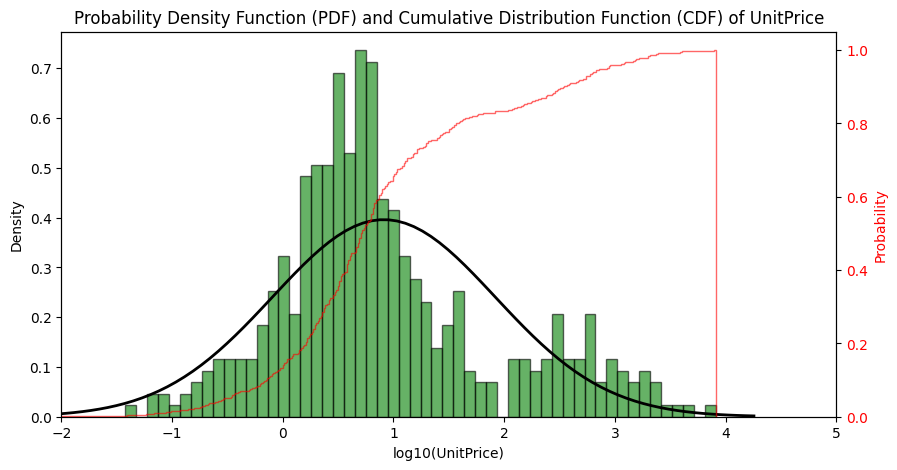

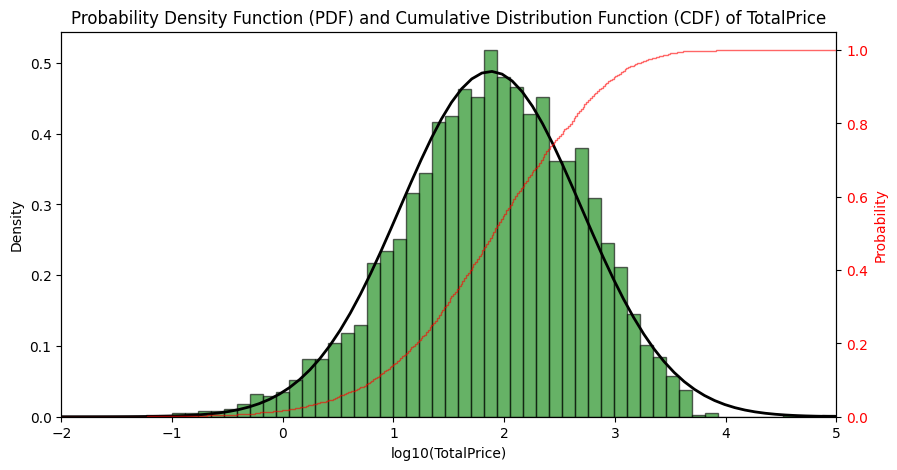

In [ ]:
for col in ["Quantity", "UnitPrice", "TotalPrice"]:
    # Calculate Frequency of each col value
    stats_df = df.groupby(col).size().reset_index(name='frequency')

    # Initialize figure and axes instances
    fig, ax1 = plt.subplots(figsize=(10, 5))
    # Axes 1
    ax1.hist(np.log10(stats_df[col]), 
            bins=70, 
            density=True,
            alpha=0.6, 
            color='g',
            edgecolor = "black")  # Histogram for empirical PDF

    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, np.mean(np.log10(stats_df[col])), 
                np.std(np.log10(stats_df[col])))  # Theoretical PDF (assuming normal distribution)

    ax1.plot(x, p, 'k', linewidth=2)
    ax1.set_title(f'Probability Density Function (PDF) and Cumulative Distribution Function (CDF) of {col}')
    ax1.set_xlabel(f'log10({col})')
    ax1.set_ylabel('Density')
    ax1.set_xlim(-2, 5)

    # Axes 2
    ax2=ax1.twinx()
    ax2.hist(np.log10(stats_df[col]), 
            bins=500, 
            density=True, 
            cumulative=True, 
            alpha=0.6, 
            color='r', 
            histtype='step')  # Empirical CDF
    ax2.set_xlim(-2, 5)
    ax2.set_ylabel('Probability', color='r')
    ax2.tick_params(axis='y', labelcolor='r');


### The Distribution of The Number of Transactions Around the World.

Number of Transactions around the world

In [ ]:
# Number of transactions in each country
stats_country_df = df.groupby(['Country','CountryCode']).size().reset_index(name="frequency")
stats_country_df.sort_values(by='frequency', ascending=False, inplace=True, ignore_index=True)
stats_country_df['log10_frequency'] = np.log10(stats_country_df['frequency'])

fig = px.choropleth(stats_country_df, locations="CountryCode",
                    color="log10_frequency", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data="frequency",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(
    title_text = 'Number of Transactions around the world'
    )
# fig.show()
fig.write_html('transactions-around-word.html')

Number of Transactions in each continent

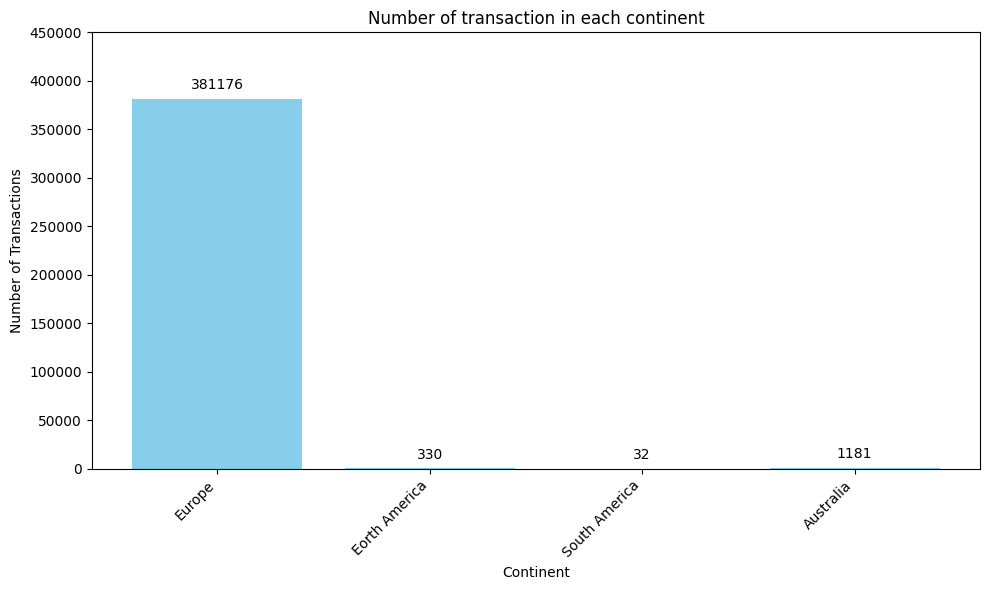

In [ ]:
# Create a dictionary contains continents (as key) and CountryCode (as value)
continents_dict = {
    'Europe' : ['NOR', "ISL", "FIN", "SWE", "DNK", 
                "GBR", 'NLD', 'BEL', "DEU", "CZE", 
                "POL", "LTU", "FRA", "CHE", "AUT", 
                "ITA", "GRC", "ESP", "PRT"],
    'Eorth America' : ["USA", "CAN"],
    'South America' : ["BRA"],
    'Australia' : ["AUS"],
}

# Calculate total transactions in each continent
total_transactions = {}
for continent , countries in continents_dict.items():
    value = stats_country_df[stats_country_df['CountryCode'].isin(countries)]['frequency'].sum()
    total_transactions[continent] = value

# Extracting keys (continents) and values (transactions) from the dictionary
continents = list(total_transactions.keys())
transactions = list(total_transactions.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(continents, transactions, color='skyblue')
# Add values on top of each bar
for i in range(len(continents)):
    plt.text(i, transactions[i] + 10000, str(transactions[i]), ha='center')
plt.xlabel('Continent')
plt.ylabel('Number of Transactions')
plt.title('Number of transaction in each continent')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.ylim(0, 450000)
plt.show()

Number of Transactions in Europe Countries

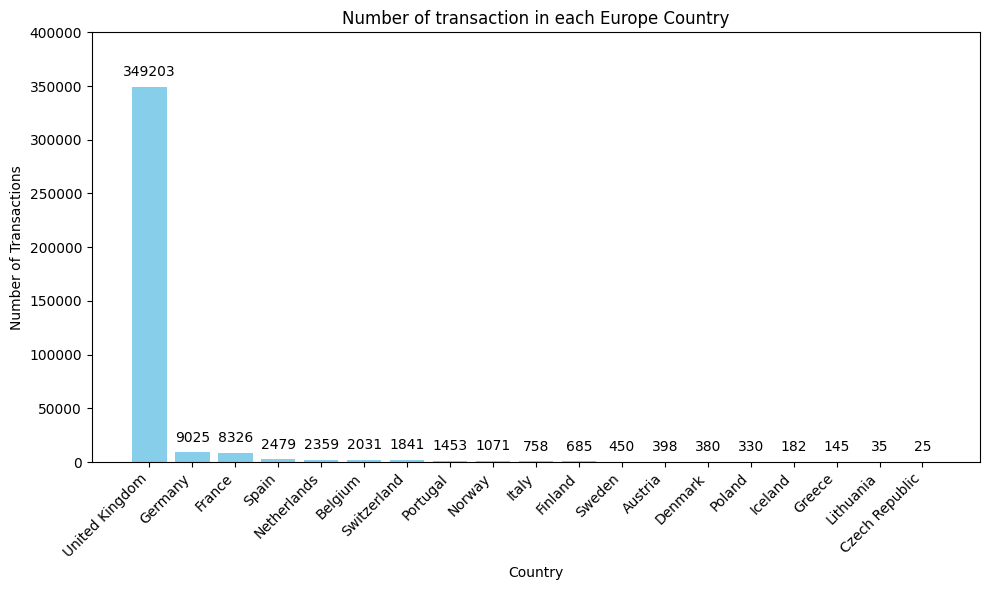

In [ ]:
europe = stats_country_df[stats_country_df['CountryCode'].isin(continents_dict["Europe"])].reset_index()
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(europe['Country'], europe['frequency'], color='skyblue')
# Add values on top of each bar
for i in range(len(europe['Country'])):
    plt.text(i, europe['frequency'].loc[i] + 10000, str(europe['frequency'].loc[i]), ha='center')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.title('Number of transaction in each Europe Country')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.ylim(0, 400000)
plt.show()

# Choropleth graph
fig = px.choropleth(europe, locations="CountryCode",
                    color="log10_frequency", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data="frequency",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(
    title_text = 'Number of Transactions in Europe Countries',
    geo_scope='europe'
    )
fig.show()

Top 10 Countries With The Highest Number Transactions

In [ ]:
fig = px.choropleth(stats_country_df.head(10), locations="CountryCode",
                    color="log10_frequency", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data="frequency",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(
    title_text = 'Top 10 Countries With The Highest Number Transactions'
    )
fig.show()


stats_country_df.head(10)

,Country,CountryCode,frequency,log10_frequency
0,United Kingdom,GBR,349203,5.543078
1,Germany,DEU,9025,3.955447
2,France,FRA,8326,3.920436
3,Spain,ESP,2479,3.394277
4,Netherlands,NLD,2359,3.372728
5,Belgium,BEL,2031,3.307710
6,Switzerland,CHE,1841,3.265054
7,Portugal,PRT,1453,3.162266
8,Australia,AUS,1181,3.072250
9,Norway,NOR,1071,3.029789


## Studying Countries by their purchase Amount

In [ ]:
canceled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom
